In [1]:
from datasets import load_dataset
# possible language pairs: https://opus.nlpl.eu/KDE4.php
data = load_dataset("kde4", lang1="en", lang2="fr")
data

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset kde4 downloaded and prepared to C:/Users/sthor/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 78.66it/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [2]:
small = data["train"].shuffle(seed=42).select(range(1_000))

In [3]:
split = small.train_test_split(seed=42)

In [4]:
split["train"][0]

{'id': '169005',
 'translation': {'en': '& Reduce Tree', 'fr': "& Refermer l' arborescence"}}

In [5]:
from transformers import AutoTokenizer

checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sthor\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip ins

In [6]:
en = split['train'][5]['translation']['en']
fr = split['train'][5]['translation']['fr']
en, fr

('You can either pick a file or enter its name in the Location: box.',
 'Vous pouvez soit choisir un fichier soit saisir son nom dans la zone de texte Emplacement.')

In [7]:
inputs = tokenizer(en)
inputs

{'input_ids': [213, 115, 1828, 8437, 15, 1437, 57, 3307, 96, 1129, 18, 4, 4577, 37, 5311, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
targets = tokenizer(text_target=fr)
targets

{'input_ids': [344, 1069, 345, 4094, 34, 2428, 345, 9315, 113, 689, 31, 8, 1283, 5, 1470, 21708, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Vous',
 '▁pouvez',
 '▁soit',
 '▁choisir',
 '▁un',
 '▁fichier',
 '▁soit',
 '▁saisir',
 '▁son',
 '▁nom',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁texte',
 '▁Emplacement',
 '.',
 '</s>']

In [10]:
# wrong language
bad_targets = tokenizer(fr)
tokenizer.convert_ids_to_tokens(bad_targets['input_ids'])

['▁V',
 'ous',
 '▁po',
 'uv',
 'ez',
 '▁so',
 'it',
 '▁cho',
 'is',
 'ir',
 '▁un',
 '▁fi',
 'chi',
 'er',
 '▁so',
 'it',
 '▁s',
 'ais',
 'ir',
 '▁son',
 '▁no',
 'm',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁text',
 'e',
 '▁Em',
 'placement',
 '.',
 '</s>']

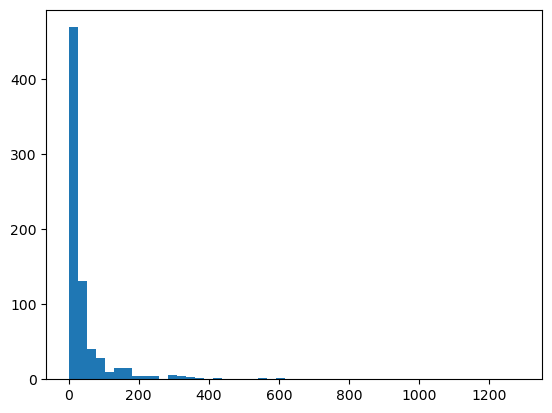

In [11]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

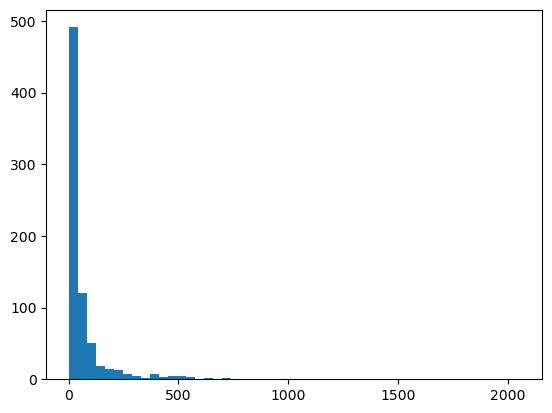

In [12]:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

In [13]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['fr'] for x in batch['translation']]

  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)

  tokenized_targets = tokenizer(
    text_target=targets, max_length=max_target_len, truncation=True)
  
  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [14]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)

In [21]:
tokenized_datasets["train"]["input_ids"][:5]

[[402, 34933, 29244, 0],
 [526, 3261, 0],
 [3492,
  3070,
  6443,
  37,
  443,
  61,
  32,
  317,
  2203,
  4824,
  514,
  1807,
  971,
  4,
  4124,
  3,
  0],
 [2167, 1398, 0],
 [526, 3261, 11223, 80, 532, 51, 1430, 2652, 0]]

In [22]:
tokenized_datasets["train"]["labels"][:5]

[[402, 9950, 108, 2240, 14, 6, 38367, 13218, 0],
 [526, 3261, 0],
 [34023,
  5,
  3948,
  5,
  372,
  402,
  38492,
  350,
  823,
  95,
  13439,
  2,
  25985,
  14,
  6,
  3996,
  3,
  0],
 [6643, 1398, 0],
 [526,
  3261,
  15481,
  51,
  8201,
  2468,
  80,
  532,
  51,
  1430,
  14185,
  243,
  24,
  751,
  20447,
  28,
  44347,
  80,
  532,
  51,
  1430,
  27,
  14,
  6,
  11800,
  5,
  898,
  526,
  3261,
  0]]

In [23]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [24]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [25]:
[tokenized_datasets["train"][i] for i in range(1, 3)]

[{'input_ids': [526, 3261, 0],
  'attention_mask': [1, 1, 1],
  'labels': [526, 3261, 0]},
 {'input_ids': [3492,
   3070,
   6443,
   37,
   443,
   61,
   32,
   317,
   2203,
   4824,
   514,
   1807,
   971,
   4,
   4124,
   3,
   0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [34023,
   5,
   3948,
   5,
   372,
   402,
   38492,
   350,
   823,
   95,
   13439,
   2,
   25985,
   14,
   6,
   3996,
   3,
   0]}]

In [27]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [28]:
batch['input_ids']

tensor([[  526,  3261,     0, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513],
        [ 3492,  3070,  6443,    37,   443,    61,    32,   317,  2203,  4824,
           514,  1807,   971,     4,  4124,     3,     0]])

In [29]:
batch['labels']

tensor([[  526,  3261,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
        [34023,     5,  3948,     5,   372,   402, 38492,   350,   823,    95,
         13439,     2, 25985,    14,     6,  3996,     3,     0]])

In [31]:
# think of seq2seq RNNs - the decoder RNN must have "some" input
# it's just like a language model where we predict the next word from
# previous words!
batch['decoder_input_ids']

tensor([[59513,   526,  3261,     0, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513],
        [59513, 34023,     5,  3948,     5,   372,   402, 38492,   350,   823,
            95, 13439,     2, 25985,    14,     6,  3996,     3]])

In [32]:
# the first token is a pad!
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁K',
 'DE',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [33]:
# the labels are one step ahead - just like a language model
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁K',
 'DE',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

In [34]:
split['train'][1]

{'id': '47571', 'translation': {'en': 'KDE', 'fr': 'KDE'}}

In [35]:
# !pip install sacrebleu bert-score

In [37]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bert_metric = load_metric("bertscore")

In [38]:
# targets must be in a list - as you recall, for bleu there can be multiple
# acceptable reference translations
bleu_metric.compute(predictions=["I love cats"], references=[["I love cats"]])

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

In [39]:
s = "Marian is an efficient NMT framework written in pure C++"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

In [40]:
bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en')

{'precision': [0.9803367853164673],
 'recall': [0.9803367853164673],
 'f1': [0.9803367853164673],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.27.3)'}

In [41]:
import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

In [42]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "finetuned-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  fp16=True,
)

In [43]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [44]:
# let's check our metrics before we start!
trainer.evaluate(max_length=max_target_len)

{'eval_loss': 1.6042920351028442,
 'eval_bleu': 24.569873882648327,
 'eval_bert_score': 0.846451632976532,
 'eval_runtime': 145.0878,
 'eval_samples_per_second': 1.723,
 'eval_steps_per_second': 0.028}

In [45]:
# may run out of gpu memory - try to restart runtime
# or get a more powerful gpu!
trainer.train()

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=72, training_loss=1.51281558142768, metrics={'train_runtime': 19.9031, 'train_samples_per_second': 113.048, 'train_steps_per_second': 3.618, 'total_flos': 50952950120448.0, 'train_loss': 1.51281558142768, 'epoch': 3.0})

In [46]:
# let's check our metrics again
trainer.evaluate(max_length=max_target_len)

{'eval_loss': 1.3954944610595703,
 'eval_bleu': 35.89748588114586,
 'eval_bert_score': 0.8702929373979569,
 'eval_runtime': 17.2026,
 'eval_samples_per_second': 14.533,
 'eval_steps_per_second': 0.233,
 'epoch': 3.0}

In [47]:
trainer.save_model("my_saved_model")

In [48]:
from transformers import pipeline
translator = pipeline("translation", model='my_saved_model', device=0)

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [49]:
translator("I hope this course has helped you on your data science journey!")

[{'translation_text': "J'espère que ce cours vous a aidé dans votre parcours data science!"}]